## To find optimal location to open a brewery in Bangalore - Week 2

### Importing libraries

In [93]:
from bs4 import BeautifulSoup
import requests
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from yellowbrick.cluster import KElbowVisualizer

import folium # map rendering library

print('Libraries imported.')

Libraries imported.


## Question 2
### Importing Geospatial data from CSV

In [2]:
raw_data = pd.read_csv("BNG_PC_LAT_LONG.csv") 

In [3]:
raw_data.head()
bangalore_data = raw_data[raw_data['regionname'] == 'Bangalore HQ']
bangalore_data = bangalore_data[pd.notnull(bangalore_data['longitude'])]
BNG_data = bangalore_data[['pincode','officename','longitude','latitude']]
BNG_data['officename'] = BNG_data['officename'].str.replace(r' S.O', '')
BNG_data.reset_index(drop=True, inplace=True)
BNG_data.rename(columns = {"pincode": "PostalCode","officename":"Neighbourhood","longitude":"Longitude","latitude":"Latitude"},inplace=True)
BNG_data

D:\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
D:\Anaconda3\lib\site-packages\pandas\core\frame.py:4025: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,PostalCode,Neighbourhood,Longitude,Latitude
0,560045,Arabic College,77.6206,13.0291
1,560103,Bellandur,77.6760,12.9298
2,560071,Domlur,77.6359,12.9611
3,560077,Dr. Shivarama Karanth Nagar,77.6293,13.0681
4,560005,Fraser Town,77.6164,13.0005
5,560065,G.K.V.K.,77.5784,13.0781
6,560008,H.A.L II Stage H.O,77.6427,12.9686
7,560001,HighCourt,77.5915,12.9773
8,560038,Indiranagar (Bangalore),77.6410,12.9815
9,560075,Jeevanbhimanagar,77.6535,12.9695


### Question 3 - Foursqaure API

In [41]:
CLIENT_ID = 'G0EH0N1VPKTW4SLJD4EQWIPA2YNIBELXHSDUT3MZCDUWESU1' # your Foursquare ID
CLIENT_SECRET = '1HKW52R4RN52GMKQCZTR2RPRKQUA4GOHUFEHRC5JDQVK3YAN' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
CATEGORY_ID = '4bf58dd8d48988d116941735' # CategoryID for BAR


print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: G0EH0N1VPKTW4SLJD4EQWIPA2YNIBELXHSDUT3MZCDUWESU1
CLIENT_SECRET:1HKW52R4RN52GMKQCZTR2RPRKQUA4GOHUFEHRC5JDQVK3YAN


In [45]:
def getNearbyVenues(names, latitudes, longitudes, radius=4000):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?categoryId{}&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CATEGORY_ID,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            500)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [46]:
bangalore_venues = getNearbyVenues(names=BNG_data['Neighbourhood'],
                                   latitudes=BNG_data['Latitude'],
                                   longitudes=BNG_data['Longitude']
                                  )

Arabic College
Bellandur
Domlur
Dr. Shivarama Karanth Nagar
Fraser Town
G.K.V.K.
H.A.L II Stage H.O
HighCourt
Indiranagar (Bangalore)
Jeevanbhimanagar
Kothanur
Mahatma Gandhi Road
Marathahalli Colony
NAL
New Thippasandra
Sadashivanagar
Sahakaranagar P.O
Vimanapura
Yelahanka
Yelahanka Satellite Town
Bangalore G.P.O. 
Ashoknagar (Bangalore)
B Sk II Stage
Bannerghatta Road
Basavanagudi H.O
Bommanahalli (Bangalore)
Bommasandra Industrial Estate
Carmelram
Chandapura
Dharmaram College
Electronics City
Gottigere
HSR Layout
Hulimavu
J P Nagar
Jayanagar H.O
Jayangar III Block
JP Nagar III Phase
Koramangala VI Bk
Mico Layout
Padmanabhnagar
St. John's Medical College
Gayathrinagar
Jalahalli East
Jalahalli H.O
Mahalakshmipuram Layout
Malleswaram
Malleswaram West
Mathikere
Msrit
Palace Guttahalli
Rajajinagar H.O
Rajajinagar IVth Block
Swimming Pool Extn
Vidyaranyapura
Vyalikaval Extn
Yeswanthpura
Channapatna H.O
Ijoor Ramangaram


In [57]:
# one hot encoding
bangalore_onehot = pd.get_dummies(bangalore_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
bangalore_onehot['Neighbourhood'] = bangalore_venues['Neighbourhood'] 

# move neighborhood column to the first column
fixed_columns = [bangalore_onehot.columns[-1]] + list(bangalore_onehot.columns[:-1])
bangalore_onehot = bangalore_onehot[fixed_columns]

bangalore_onehot.head()

,Neighbourhood,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Candy Store,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gym,Gym / Fitness Center,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Neighborhood,Nightclub,North Indian Restaurant,Outlet Store,Pakistani Restaurant,Park,Parsi Restaurant,Performing Arts Venue,Pizza Place,Plaza,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Resort,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Arabic College,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Arabic College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Arabic College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Arabic College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Arabic College,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

### Cleaning data to get the neighbourhoods with no existing brewery, which could be a starting point to look for a neighbourhood to open a brewery

In [116]:
bangalore_grouped = bangalore_onehot.groupby('Neighbourhood').mean()
bangalore_grouped = bangalore_grouped.loc[bangalore_grouped['Brewery'] == 0.0].reset_index()
bangalore_grouped.head()

,Neighbourhood,Afghan Restaurant,Airport,American Restaurant,Andhra Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Automotive Shop,BBQ Joint,Badminton Court,Bakery,Bar,Bed & Breakfast,Beer Garden,Bengali Restaurant,Bistro,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Bubble Tea Shop,Building,Burger Joint,Burrito Place,Bus Station,Butcher,Cafeteria,Café,Candy Store,Chettinad Restaurant,Chinese Restaurant,Chocolate Shop,Clothing Store,Cocktail Bar,Coffee Shop,Concert Hall,Convenience Store,Creperie,Cricket Ground,Cupcake Shop,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Dive Bar,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Field,Financial or Legal Service,Flea Market,Food,Food & Drink Shop,Food Court,Food Truck,French Restaurant,Fried Chicken Joint,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,General Entertainment,German Restaurant,Golf Course,Gym,Gym / Fitness Center,History Museum,Hookah Bar,Hot Dog Joint,Hotel,Hotel Bar,Hyderabadi Restaurant,Ice Cream Shop,Indian Chinese Restaurant,Indian Restaurant,Indian Sweet Shop,Indie Movie Theater,Irish Pub,Italian Restaurant,Japanese Restaurant,Jewelry Store,Juice Bar,Karnataka Restaurant,Kebab Restaurant,Kerala Restaurant,Korean Restaurant,Lake,Light Rail Station,Liquor Store,Lounge,Market,Mediterranean Restaurant,Mexican Restaurant,Middle Eastern Restaurant,Mobile Phone Shop,Monument / Landmark,Motorcycle Shop,Movie Theater,Multicuisine Indian Restaurant,Multiplex,Music Venue,Neighborhood,Nightclub,North Indian Restaurant,Outlet Store,Pakistani Restaurant,Park,Parsi Restaurant,Performing Arts Venue,Pizza Place,Plaza,Pub,Punjabi Restaurant,Racetrack,Rajasthani Restaurant,Recreation Center,Resort,Restaurant,Road,Salad Place,Salon / Barbershop,Sandwich Place,Seafood Restaurant,Shop & Service,Shopping Mall,Smoke Shop,Snack Place,Soccer Field,Soccer Stadium,South Indian Restaurant,Spa,Sporting Goods Shop,Sports Bar,Stadium,Steakhouse,Supermarket,Sushi Restaurant,Szechuan Restaurant,Tea Room,Thai Restaurant,Theater,Toy / Game Store,Trail,Train Station,Udupi Restaurant,Vegetarian / Vegan Restaurant,Vietnamese Restaurant,Wine Bar,Women's Store,Yoga Studio
0,Bommasandra Industrial Estate,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.030303,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.121212,0.0,0.0,0.030303,0.0,0.00,0.0,0.090909,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.030303,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.060606,0.0,0.0,0.0,0.000000,0.0,0.060606,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.181818,0.0,0.0,0.000000,0.0,0.181818,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.030303,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.060606,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.030303,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.030303,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.030303,0.0,0.030303,0.00,0.0,0.0,0.0
1,Chandapura,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.000000,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.00,0.000000,0.0,0.0,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.00,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0000,0.0,0.0,0.000000,0.0,0.00,0.0,0.0,0.00,0.0,0.0,0.125000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.00,0.00,0.00,0.0,0.0,0.0,0.250000,0.0,0.0,0.000000,0.0,0.125000,0.0,0.00,0.0,0.00,0.0,0.0,0.000000,0.00,0.0,0.000000,0.0,0.0,0.0,0.00,0.00,0.000000,0.0,0.00,0.0,0.0,0.00,0.00,0.00,0.000000,0.00,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.00,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.125000,0.0,0.000000,0.00,0.0,0.0,0.0
2,Channapatna H.O,0.0,0.0,0.

In [117]:
num_top_venues = 5

for hood in bangalore_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = bangalore_grouped[bangalore_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Bommasandra Industrial Estate----
               venue  freq
0              Hotel  0.18
1  Indian Restaurant  0.18
2               Café  0.12
3        Coffee Shop  0.09
4        Pizza Place  0.06


----Chandapura----
                 venue  freq
0                Hotel  0.25
1          Pizza Place  0.12
2    Indian Restaurant  0.12
3          Coffee Shop  0.12
4  Sporting Goods Shop  0.12


----Channapatna H.O----
               venue  freq
0  Indian Restaurant  0.25
1        Coffee Shop  0.25
2      Train Station  0.25
3        Bus Station  0.25
4  Afghan Restaurant  0.00


----Electronics City----
               venue  freq
0              Hotel  0.15
1        Coffee Shop  0.10
2  Indian Restaurant  0.10
3               Café  0.08
4        Pizza Place  0.08


----Gayathrinagar----
               venue  freq
0  Indian Restaurant  0.14
1              Hotel  0.06
2     Ice Cream Shop  0.06
3        Coffee Shop  0.05
4          Multiplex  0.04


----Gottigere----
                  venu

In [118]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

### Getting people interest by looking into common venues, this can be used to refine neighbourhood to open a brewery

In [119]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighbourhood'] = bangalore_grouped['Neighbourhood']

for ind in np.arange(bangalore_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(bangalore_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bommasandra Industrial Estate,Hotel,Indian Restaurant,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Food Court,Vegetarian / Vegan Restaurant,Train Station,Market
1,Chandapura,Hotel,Pizza Place,Coffee Shop,Train Station,Sporting Goods Shop,Indian Restaurant,Fast Food Restaurant,Dive Bar,Falafel Restaurant,Electronics Store
2,Channapatna H.O,Coffee Shop,Train Station,Indian Restaurant,Bus Station,Diner,Farmers Market,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
3,Electronics City,Hotel,Coffee Shop,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Department Store,Food Court,Asian Restaurant,Juice Bar
4,Gayathrinagar,Indian Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Multiplex,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Bowling Alley,Italian Restaurant
5,Gottigere,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Resort,Italian Restaurant,Chinese Restaurant,Department Store,Multiplex,Clothing Store
6,Ijoor Ramangaram,Indian Restaurant,Performing Arts Venue,Bus Station,South Indian Restaurant,Breakfast Spot,Train Station,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant
7,Jalahalli East,Coffee Shop,Indian Restaurant,Hotel,Ice Cream Shop,Pizza Place,Plaza,Restaurant,Italian Restaurant,Park,Train Station
8,Jalahalli H.O,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Café,Hotel,Park
9,Malleswaram,Indian Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Multiplex,Bowling Alley,Pub,Italian Restaurant,Bakery,Fast Food Restaurant


### Clustering neighbourhood

#### Find cluster based on elbow method

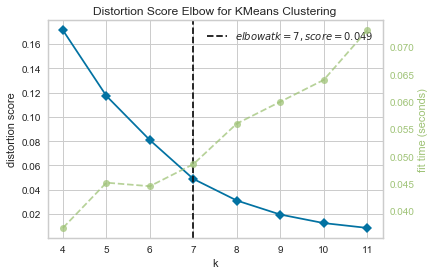

In [120]:
X = bangalore_grouped_clustering

# Instantiate the clustering model and visualizer
model = KMeans(n_clusters=kclusters, random_state=0)
visualizer = KElbowVisualizer(model, k=(4,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show()        # Finalize and render the figure


In [121]:
# set number of clusters =
kclusters = 7 ## Got it from elbow method.

bangalore_grouped_clustering = bangalore_grouped.drop('Neighbourhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(bangalore_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([4, 3, 1, 4, 0, 6, 2, 5, 6, 0])

In [122]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

bangalore_merged = BNG_data

# merge bangalore_merged with BNG_data to add latitude/longitude for each neighborhood
bangalore_merged = bangalore_merged.join(neighborhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

bangalore_merged = bangalore_merged.dropna()

bangalore_merged.head() # check the last columns!

,PostalCode,Neighbourhood,Longitude,Latitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,560080,Sadashivanagar,77.5772,13.0094,0.0,Indian Restaurant,Ice Cream Shop,Coffee Shop,Hotel,Fast Food Restaurant,Bakery,Pub,Chinese Restaurant,Multiplex,Bowling Alley
26,560099,Bommasandra Industrial Estate,77.6878,12.8203,4.0,Hotel,Indian Restaurant,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Food Court,Vegetarian / Vegan Restaurant,Train Station,Market
28,560081,Chandapura,77.7041,12.8016,3.0,Hotel,Pizza Place,Coffee Shop,Train Station,Sporting Goods Shop,Indian Restaurant,Fast Food Restaurant,Dive Bar,Falafel Restaurant,Electronics Store
30,560100,Electronics City,77.6626,12.8400,4.0,Hotel,Coffee Shop,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Department Store,Food Court,Asian Restaurant,Juice Bar
31,560083,Gottigere,77.5883,12.8564,6.0,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Resort,Italian Restaurant,Chinese Restaurant,Department Store,Multiplex,Clothing Store


In [82]:
address = 'Bangalore, India'

geolocator = Nominatim(user_agent="BNG_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Bangalore are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Bangalore are 12.9791198, 77.5912997.


In [125]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(bangalore_merged['Latitude'], bangalore_merged['Longitude'], bangalore_merged['Neighbourhood'], bangalore_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster)-1],
        fill=True,
        fill_color=rainbow[int(cluster)-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Clusters

In [139]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 0, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Sadashivanagar,Indian Restaurant,Ice Cream Shop,Coffee Shop,Hotel,Fast Food Restaurant,Bakery,Pub,Chinese Restaurant,Multiplex,Bowling Alley
42,Gayathrinagar,Indian Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Multiplex,Fast Food Restaurant,Chinese Restaurant,Clothing Store,Bowling Alley,Italian Restaurant
46,Malleswaram,Indian Restaurant,Hotel,Ice Cream Shop,Coffee Shop,Multiplex,Bowling Alley,Pub,Italian Restaurant,Bakery,Fast Food Restaurant
47,Malleswaram West,Indian Restaurant,Ice Cream Shop,Hotel,Coffee Shop,Bakery,Bowling Alley,Italian Restaurant,Multiplex,Fast Food Restaurant,Department Store
49,Msrit,Indian Restaurant,Ice Cream Shop,Italian Restaurant,Pizza Place,Chinese Restaurant,Fast Food Restaurant,Coffee Shop,Hotel,Bowling Alley,Café
51,Rajajinagar H.O,Indian Restaurant,Multiplex,Coffee Shop,Hotel,Café,Chinese Restaurant,Bowling Alley,Clothing Store,Department Store,Bakery
52,Rajajinagar IVth Block,Indian Restaurant,Hotel,Coffee Shop,Lounge,Bakery,Multiplex,Ice Cream Shop,Fast Food Restaurant,Clothing Store,Shopping Mall
55,Vyalikaval Extn,Indian Restaurant,Hotel,Coffee Shop,Ice Cream Shop,Multiplex,Pub,Fast Food Restaurant,Bakery,Department Store,Gym


In [140]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 1, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
57,Channapatna H.O,Coffee Shop,Train Station,Indian Restaurant,Bus Station,Diner,Farmers Market,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [141]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 2, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
58,Ijoor Ramangaram,Indian Restaurant,Performing Arts Venue,Bus Station,South Indian Restaurant,Breakfast Spot,Train Station,Falafel Restaurant,Electronics Store,Eastern European Restaurant,Dumpling Restaurant


In [142]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 3, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Chandapura,Hotel,Pizza Place,Coffee Shop,Train Station,Sporting Goods Shop,Indian Restaurant,Fast Food Restaurant,Dive Bar,Falafel Restaurant,Electronics Store


In [143]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 4, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
26,Bommasandra Industrial Estate,Hotel,Indian Restaurant,Café,Coffee Shop,Fast Food Restaurant,Pizza Place,Food Court,Vegetarian / Vegan Restaurant,Train Station,Market
30,Electronics City,Hotel,Coffee Shop,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Department Store,Food Court,Asian Restaurant,Juice Bar


In [144]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 5, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
43,Jalahalli East,Coffee Shop,Indian Restaurant,Hotel,Ice Cream Shop,Pizza Place,Plaza,Restaurant,Italian Restaurant,Park,Train Station


In [145]:
bangalore_merged.loc[bangalore_merged['Cluster Labels'] == 6, bangalore_merged.columns[[1] + list(range(5, bangalore_merged.shape[1]))]]

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
31,Gottigere,Indian Restaurant,Pizza Place,Café,Fast Food Restaurant,Resort,Italian Restaurant,Chinese Restaurant,Department Store,Multiplex,Clothing Store
44,Jalahalli H.O,Indian Restaurant,Ice Cream Shop,Chinese Restaurant,Fast Food Restaurant,Pizza Place,Italian Restaurant,Coffee Shop,Café,Hotel,Park


### From initial cluster anaylysis, Cluster 0 seems to be a promising location to open a Brewery location at the common venue in this cluster. This is very basic approach and it can be refined further based on other data points like income group, demographics etc.